In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, WeightedRandomSampler
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import pandas as pd
import numpy as np
from collections import Counter

class EyeDiseaseDataset(Dataset):
    def __init__(self, tiff_dir=None, png_dir=None, csv_file=None, transform=None):
        self.image_paths = []
        self.labels = []
        self.valid_indices = []
        self.transform = transform
        self.png_dir = png_dir  

        # Load TIFF images
        if tiff_dir and os.path.exists(tiff_dir):
            tiff_files = [f for f in os.listdir(tiff_dir) if f.lower().endswith('.tif')]
            self.image_paths.extend([os.path.join(tiff_dir, f) for f in tiff_files])
            self.labels.extend([2] * len(tiff_files))  # Label TIFF files as 'disease'
        elif tiff_dir:
            raise ValueError(f"TIFF directory '{tiff_dir}' not found.")

        # Load PNG images from CSV
        if csv_file and png_dir:  
            if not os.path.exists(csv_file):
                raise ValueError(f"CSV file '{csv_file}' not found.")
            if not os.path.exists(png_dir):
                raise ValueError(f"PNG directory '{png_dir}' not found.")

            data = pd.read_csv(csv_file).dropna()  # Drop missing values
            data.iloc[:, 0] = data.iloc[:, 0].astype(str)  # Ensure filenames are strings

            label_mapping = {
                "normal": 0, 
                "mild": 1, 
                "moderate": 1, 
                "severe": 1 }

            png_files = [os.path.join(png_dir, f) for f in data.iloc[:, 0]]  
            valid_png_files = [f for f in png_files if os.path.exists(f)]  
            
            self.image_paths.extend(valid_png_files)
            self.labels.extend(data.iloc[:, 1].map(label_mapping).values[:len(valid_png_files)])

        # Filter invalid images
        self.valid_indices = [i for i in range(len(self.image_paths)) if os.path.exists(self.image_paths[i])]

    def __len__(self):
        return len(self.valid_indices)



    def __getitem__(self, idx):
        idx = self.valid_indices[idx]  # Get valid index
        image_path = self.image_paths[idx]

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Skipping file {image_path} due to error: {e}")
            return None, None  # Return None instead of recursive call

        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx]

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Paths

tiff_dir = r"C:\Users\Ludovic\Pytorch\ExpoSciences\Datasets\Blue_Light"

# Collect all TIFF files from both directories
csv_file = r"C:\Users\Ludovic\Pytorch\ExpoSciences\Datasets\26172919\SLID_E_information.csv"
png_dir = r"C:\Users\Ludovic\Pytorch\ExpoSciences\Datasets\26172919\train\train"

# Create dataset
full_dataset = EyeDiseaseDataset(tiff_dir=tiff_dir, csv_file=csv_file, png_dir=png_dir, transform=transform)

dataset = EyeDiseaseDataset(tiff_dir=tiff_dir, png_dir=png_dir, csv_file=csv_file, transform=transform)

num_tiff = sum(1 for path in dataset.image_paths if path.endswith('.tif'))
num_png = sum(1 for path in dataset.image_paths if path.endswith('.png'))

print(f"Total images in dataset: {len(dataset)}")
print(f"TIFF images: {num_tiff}")
print(f"PNG images: {num_png}")

# Handle class imbalance
label_counts = Counter(full_dataset.labels)
class_weights = {label: 1.0 / count for label, count in label_counts.items()}
sample_weights = [class_weights[label] for label in full_dataset.labels]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

# Check if dataset is empty before splitting
if len(full_dataset) == 0:
    raise ValueError("Dataset is empty. Check file paths and data integrity.")

# Split dataset into train and validation sets
train_indices, val_indices = train_test_split(range(len(full_dataset)), test_size=0.2, random_state=42)
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

# Create DataLoaders, filtering out None values
def collate_fn(batch):
    batch = [b for b in batch if b[0] is not None]
    return torch.utils.data.dataloader.default_collate(batch) if batch else None

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Model definition
class EyeDiseaseModel(nn.Module):
    def __init__(self, num_classes=3):  # Three classes: normal (0), epiphora (1), disease (2)
        super(EyeDiseaseModel, self).__init__()
        self.model = models.resnet18(pretrained=True)  

        for param in self.model.parameters():
            param.requires_grad = False  # Freeze base model weights

        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # Modify final layer

    def forward(self, x):
        return self.model(x)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EyeDiseaseModel(num_classes=3).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training function
import torch
import os

# Model file path
MODEL_PATH = "best_model.pth"

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=2):
    # If a saved model exists, ask user for choice
    if os.path.exists(MODEL_PATH):
        choice = input("A saved model was found. Enter 'train' to retrain or 'load' to use the existing model: ").strip().lower()

        if choice == "load":
            print("Loading existing model instead of training.")
            model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
            model.eval()
            return
        elif choice != "train":
            print("Invalid input. Defaulting to loading model.")
            model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
            model.eval()
            return
    
    print("No saved model found or user chose to train. Starting training...")

    best_accuracy = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for batch in train_loader:
            if batch is None: continue  # Skip empty batches
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

        train_accuracy = 100 * correct_preds / total_preds
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")

        # Validation
        model.eval()
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():
            for batch in val_loader:
                if batch is None: continue  # Skip empty batches
                inputs, labels = batch
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_accuracy = 100 * correct_preds / total_preds
        print(f"Validation Accuracy: {val_accuracy:.2f}%")

        # Save best model automatically
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), MODEL_PATH)
            print(f"New best model saved with accuracy: {val_accuracy:.2f}%")

    print("Training Complete")

# Run training (if necessary)
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1)

# Load the best model automatically after training
print("Loading the best saved model...")
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model.eval()
print("Model loaded successfully!")

# Class labels mapping
class_names = {0: "normal", 1: "epiphora", 2: "keratitis"}

def predict(image_path):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    
    # Perform multiple augmented predictions
    predictions = []
    for _ in range(5):  # 5 augmented versions
        transformed_image = transform(image).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(transformed_image)
            _, predicted = torch.max(output, 1)
            predictions.append(predicted.item())

    final_prediction = max(set(predictions), key=predictions.count)  # Majority vote
    return class_names[final_prediction]

    

image_path = r'C:\Users\Ludovic\Pytorch\ExpoSciences\OIP.jpg'
predicted_label = predict(image_path)
print(f"Predicted Class: {predicted_label}")  



Total images in dataset: 2239
TIFF images: 133
PNG images: 0


c:\Users\Ludovic\anaconda3\envs\AnExpoProject\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ludovic\anaconda3\envs\AnExpoProject\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


No saved model found or user chose to train. Starting training...
Epoch [1/1], Loss: 0.7580, Train Accuracy: 74.26%
Validation Accuracy: 81.03%
New best model saved with accuracy: 81.03%
Training Complete
Loading the best saved model...
Model loaded successfully!
Predicted Class: normal


C:\Users\Ludovic\AppData\Local\Temp\ipykernel_36584\1157750739.py:234: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_PATH, map_locatio

In [3]:
from collections import Counter

# Assuming you have a dataset with (image, label) format
train_labels = [label for _, label in train_dataset]  # Extract labels
val_labels = [label for _, label in val_dataset]      # Extract labels

# Count occurrences
train_distribution = Counter(train_labels)
val_distribution = Counter(val_labels)

print("📊 Train Label Distribution:", train_distribution)
print("📊 Validation Label Distribution:", val_distribution)


📊 Train Label Distribution: Counter({np.int64(0): 1425, np.int64(1): 258, 2: 108})
📊 Validation Label Distribution: Counter({np.int64(0): 363, np.int64(1): 60, 2: 25})


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import pandas as pd

In [5]:
print("PNG Directory:", png_dir)
print("CSV File:", csv_file)


PNG Directory: C:\Users\Ludovic\Pytorch\ExpoSciences\Datasets\26172919\train\train
CSV File: C:\Users\Ludovic\Pytorch\ExpoSciences\Datasets\26172919\SLID_E_information.csv


In [6]:
print(f"PNG files in directory {png_dir}:")
png_files = [f for f in os.listdir(png_dir) if f.lower().endswith('.png')]
print(png_files[:5])  # Print first 5 files


PNG files in directory C:\Users\Ludovic\Pytorch\ExpoSciences\Datasets\26172919\train\train:
[]


In [7]:
data = pd.read_csv(csv_file)
print(data.head())  # Print first few rows of CSV to check structure


                         Filename epiphora_stage partition_group
0  36682796b620220620010S_04R.jpg         normal            test
1  15ce8062cf20201222004S_11R.jpg         normal           train
2  0b2699433820201231006S_01R.jpg         normal           train
3  6f86ecfd8020201225005S_02L.jpg         normal           train
4  980bac2f5c20201216010S_07L.jpg         normal           train


In [8]:
print(f"PNG Directory: {png_dir}")


PNG Directory: C:\Users\Ludovic\Pytorch\ExpoSciences\Datasets\26172919\train\train


In [9]:
if os.path.exists(png_dir):
    print("PNG directory exists.")
else:
    print("PNG directory does not exist.")


PNG directory exists.


In [10]:
all_files = os.listdir(png_dir)
print("All files in the PNG directory:", all_files[:5])  # Print first 5 files


All files in the PNG directory: ['014b7a540d20210802011S_02R.jpg', '014b7a540d20210802011S_03L.jpg', '01580d597320220914002S_04R.jpg', '01580d597320220914002S_13L.jpg', '016e67720c20210819002S_17L.jpg']


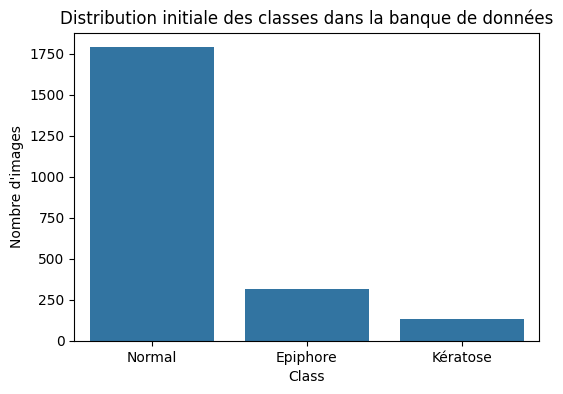

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of samples per class
label_counts = pd.Series(full_dataset.labels).value_counts()

# Plot the distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.xticks(ticks=[0, 1, 2], labels=["Normal", "Epiphore", "Kératose"])
plt.xlabel("Class")
plt.ylabel("Nombre d'images")
plt.title("Distribution initiale des classes dans la banque de données")
plt.show()


In [12]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Load CSV file
csv_file = "C:/Users/Ludovic/Pytorch/ExpoSciences/Datasets/26172919/SLID_E_information.csv"
png_dir = "C:/Users/Ludovic/Pytorch/ExpoSciences/Datasets/26172919/train/train"

data = pd.read_csv(csv_file)

# Display first few rows
print(data.head())

# Show column names and data types
print(data.info())

# Count missing values
print("Missing values per column:\n", data.isnull().sum())


                         Filename epiphora_stage partition_group
0  36682796b620220620010S_04R.jpg         normal            test
1  15ce8062cf20201222004S_11R.jpg         normal           train
2  0b2699433820201231006S_01R.jpg         normal           train
3  6f86ecfd8020201225005S_02L.jpg         normal           train
4  980bac2f5c20201216010S_07L.jpg         normal           train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Filename         2629 non-null   object
 1   epiphora_stage   2999 non-null   object
 2   partition_group  2999 non-null   object
dtypes: object(3)
memory usage: 70.4+ KB
None
Missing values per column:
 Filename           370
epiphora_stage       0
partition_group      0
dtype: int64


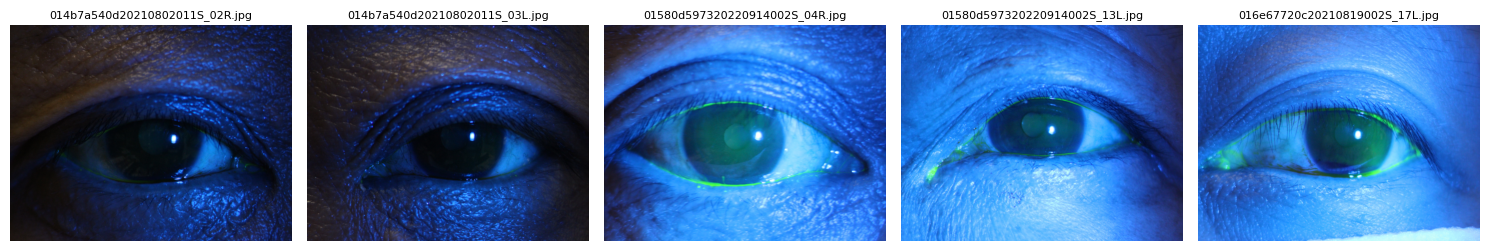

In [13]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def show_images(png_dir, num_images=5):
    png_files = [f for f in os.listdir(png_dir) if f.lower().endswith('.jpg')]

    if len(png_files) == 0:
        print("No JPG images found!")
        return

    plt.figure(figsize=(15, 5))  # Increase figure size

    for i, img_name in enumerate(png_files[:num_images]):
        img_path = os.path.join(png_dir, img_name)
        try:
            img = Image.open(img_path)
            plt.subplot(1, num_images, i + 1)
            plt.imshow(img)
            plt.axis("off")
            plt.title(img_name, fontsize=8, wrap=True)  # Reduce font size & wrap text
        except Exception as e:
            print(f"Error loading {img_name}: {e}")

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

show_images(png_dir, num_images=5)


In [14]:
# Load the model correctly
model = EyeDiseaseModel(num_classes=3).to(device)
model.load_state_dict(torch.load(MODEL_PATH, map_location=device))  
model.eval()  # Set to evaluation mode


c:\Users\Ludovic\anaconda3\envs\AnExpoProject\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ludovic\anaconda3\envs\AnExpoProject\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Ludovic\AppData\Local\Temp\ipykernel_36584\2563435150.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https:/

EyeDiseaseModel(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

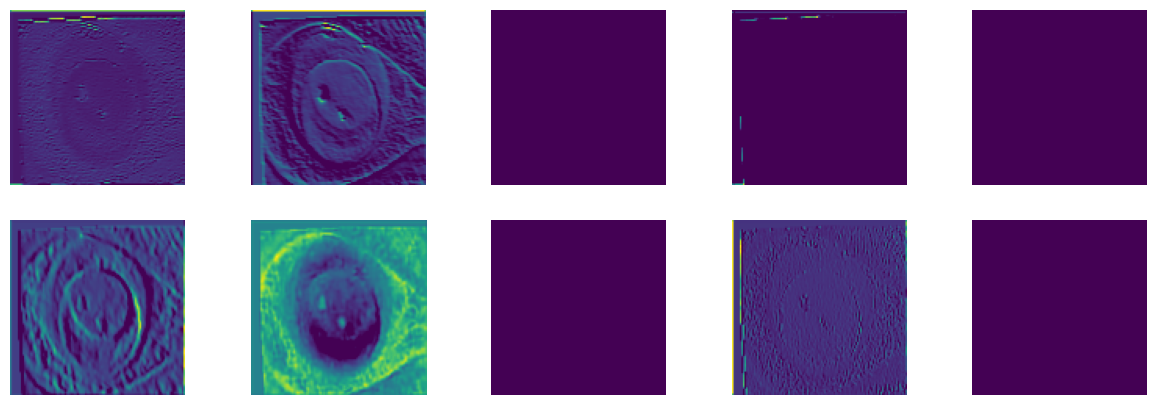

In [15]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

def show_feature_maps(model, image_path, layer_num=0):
    """Visualize feature maps from a specific layer in the CNN."""
    model.eval()
    
    # Load and preprocess the image
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    # Extract features from an intermediate layer
    activation = None

    def hook_fn(module, input, output):
        nonlocal activation
        activation = output.detach()

    # Hook into a convolutional layer
    layer = list(model.model.children())[layer_num]  # Get layer by index
    hook = layer.register_forward_hook(hook_fn)
    
    # Forward pass
    _ = model(img_tensor)
    hook.remove()  # Remove hook after forward pass

    # Plot feature maps
    if activation is not None:
        num_feature_maps = activation.shape[1]
        plt.figure(figsize=(15, 5))
        for i in range(min(10, num_feature_maps)):  # Show only first 10 feature maps
            plt.subplot(2, 5, i + 1)
            plt.imshow(activation[0, i].cpu().numpy(), cmap="viridis")
            plt.axis("off")
        plt.show()
    else:
        print("Feature maps could not be extracted.")

# Call the function with an image
show_feature_maps(model, r"C:\Users\Ludovic\Pytorch\ExpoSciences\OIP.jpg", layer_num=1)  # Try different layers



In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# 🔍 Find the last convolutional layer dynamically
def get_last_conv_layer(model):
    for name, module in reversed(list(model.named_modules())):  # Convert to list and reverse
        if isinstance(module, nn.Conv2d):
            return name, module
    raise ValueError("No convolutional layer found in model!")

#  Grad-CAM Implementation
def grad_cam(model, image_path):
    model.eval()
    
    # Get last conv layer dynamically
    layer_name, target_layer = get_last_conv_layer(model)
    print(f"Using last conv layer: {layer_name}")

    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output)  # Store forward activations

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])  # Store gradients from backward pass

    # Register hooks
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # Load and preprocess image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(next(model.parameters()).device)

    # Forward pass
    output = model(input_tensor)
    class_idx = torch.argmax(output).item()

    # Backward pass
    model.zero_grad()
    output[0, class_idx].backward()

    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    # Ensure gradients and activations were captured
    if not gradients or not activations:
        raise RuntimeError("Gradients or activations were not captured. Check if the model has frozen layers.")

    gradients = gradients[0]  # Extract from list
    activations = activations[0]  # Extract from list

    # Compute Grad-CAM heatmap
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze().cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)  # Normalize

    # Overlay heatmap on image
    heatmap = cv2.resize(heatmap, (image.size[0], image.size[1]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    img = np.array(image)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    # Show results
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM for class {class_idx}")
    plt.axis("off")

    plt.show()

# 🏃 Run Grad-CAM
image_path = r'C:\Users\Ludovic\Pytorch\ExpoSciences\OIP.jpg'
grad_cam(model, image_path)


Using last conv layer: model.layer4.1.conv2


RuntimeError: Gradients or activations were not captured. Check if the model has frozen layers.